In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Correlation Analysis
First we want to analyze how long our Ising systems take to equilibrate, and how many configurations we have to throw away between successive samples to avoid temporal correlations.

The former point is addressed by calculating the nonlinear correlation function

\begin{equation}
\large
\Phi_\sigma^{nl}(t) = \frac{\langle s(t)\rangle - \langle s(\infty)\rangle}{\langle s(t_0)\rangle - \langle s(\infty)\rangle} \sim \exp\left(-\frac{t}{\tau^{nl}}\right).
\end{equation}

Similarly, the latter point can be taken care of by computing the linear correlation function

\begin{equation}
\large
\Phi_\sigma(t) = \frac{\langle s(t_0)\cdot s(t)\rangle - \langle s(t_0)\rangle^2}{\langle s(t_0)^2\rangle - \langle s(t_0)\rangle^2} \sim \exp\left(-\frac{t}{\tau}\right).
\end{equation}

We can then extract the correlation times $\tau^{nl}$, $\tau$, from which we find the number of thermalization steps ($c\cdot\tau^{nl}$) and the sample stride ($c\cdot\tau$), with $c\sim 3$.

Note that close to the critical temperature, the above scaling isn't necessarily valid.

### Data Import
The data needed for the analysis outlined above is generated by the `correlation_analysis.cpp` program.

In [2]:
dataFrame_8 = pd.read_csv(f"corrdata_8x8x8.csv")
dataFrame_16 = pd.read_csv(f"corrdata_16x16x16.csv")
dataFrame_32 = pd.read_csv(f"corrdata_32x32x32.csv")

In [3]:
dataFrame_8

,Number Of Temperatures,Temperature 0,Thermalization Magnetization 0,Linear Phi 0,Temperature 1,Thermalization Magnetization 1,Linear Phi 1,Temperature 2,Thermalization Magnetization 2,Linear Phi 2
0,3.0,4.0,-0.999922,1.000000,5.0,-0.999687,0.995919,6.0,-0.999375,1.000000
1,NaN,NaN,-0.999922,1.000000,NaN,-0.999687,0.995919,NaN,-0.999375,1.000000
2,NaN,NaN,-0.999844,0.992102,NaN,-0.999609,0.991838,NaN,-0.998984,1.000000
3,NaN,NaN,-0.999609,0.992102,NaN,-0.998984,0.987756,NaN,-0.998516,1.000000
4,NaN,NaN,-0.999062,0.992102,NaN,-0.998516,0.987756,NaN,-0.998125,1.000000
...,...,...,...,...,...,...,...,...,...,...
10236,NaN,NaN,-0.748594,-0.003085,NaN,-0.193438,-0.024375,NaN,0.016875,-0.056040
10237,NaN,NaN,-0.749062,-0.003085,NaN,-0.193359,-0.024375,NaN,0.016563,-0.052055
10238,NaN,NaN,-0.748516,-0.003085,NaN,-0.193828,-0.024375,NaN,0.016484,-0.048070
10239,NaN,NaN,-0.748359,0.004813,NaN,-0.193906,-0.028457,NaN,0.016406,-0.044085


## 1.1 Linear Tau Analysis
Below we fit exponential functions to the calculated correlation functions $\Phi_\sigma(t)$ for different system sizes and different temperatures. This allows the extraction of the correlation time $\tau$. The fits are generated automatically, so there is quite a bit of error involved. At least we get results in the right ballpark. Hand-tuning the fits could certainly improve the results.

The take-away here is that correlations typically die within about one to two sweeps. This means we should discard $\sim 5\cdot L^3$ configurations between successive samples.

In [4]:
def Perform_Linear_Correlation_Analysis(dataframe, linear_size):
    num_temps = int(dataframe.loc[:,"Number Of Temperatures"].values[0])
    print(f"num_temps: {num_temps}")
    fig,axs = plt.subplots(num_temps, sharex='all', figsize=(7,10))
    fig.suptitle(f"Linear correlations in a {linear_size}x{linear_size}x{linear_size} Ising system", fontsize=20)
    for i in range(num_temps):
        name = f'Linear Phi {i}'
        temperature = dataframe.loc[:,f'Temperature {i}'].values[0]
        data = dataframe.loc[:,name].values
        upper_bound = 0
        while(upper_bound+1 < len(data) and data[upper_bound+1] > 0.05):
            upper_bound += 1
        if(upper_bound == 0):
            continue
        axs[i].plot(data[:upper_bound], label=r'$\Phi_\sigma$')
        m,b = np.polyfit(np.arange(upper_bound),np.log(data[:upper_bound]),1)
        tau = -1./m
        axs[i].plot(np.exp(m*np.arange(upper_bound)+b), label=fr'fit at $\tau={tau:.0f}$', ls='dashed')
        axs[i].set_title(fr"Temperature {temperature}, $\tau \approx {tau/linear_size**3:.1f}$ sweeps", fontsize=15)
        axs[i].set_ylabel("Correlation to initial state", fontsize=12)
        axs[i].legend(prop={'size': 12})
    plt.xlabel('Time in single spin updates', fontsize=12)
    print(f"One sweep corresponds to {linear_size*linear_size*linear_size} updates")

num_temps: 3
One sweep corresponds to 512 updates


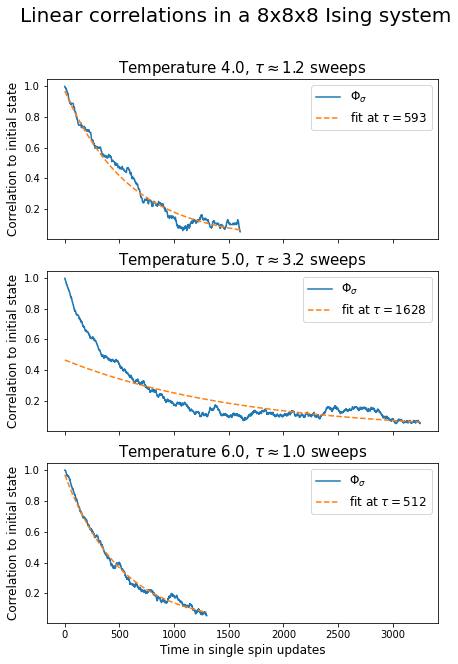

In [5]:
Perform_Linear_Correlation_Analysis(dataFrame_8, 8)

num_temps: 3
One sweep corresponds to 4096 updates


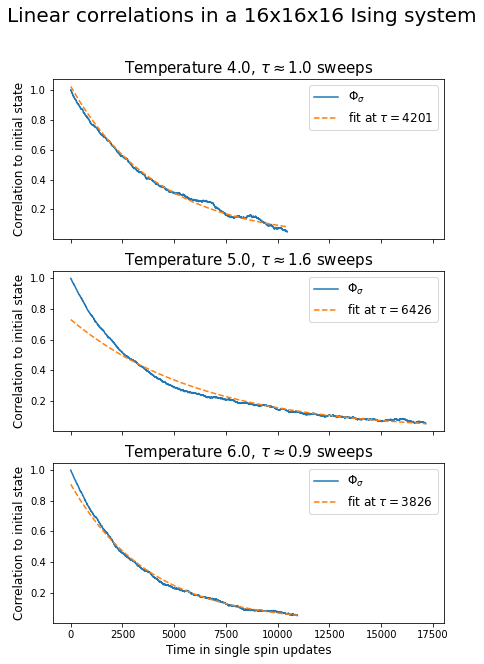

In [6]:
Perform_Linear_Correlation_Analysis(dataFrame_16, 16)

num_temps: 3
One sweep corresponds to 32768 updates


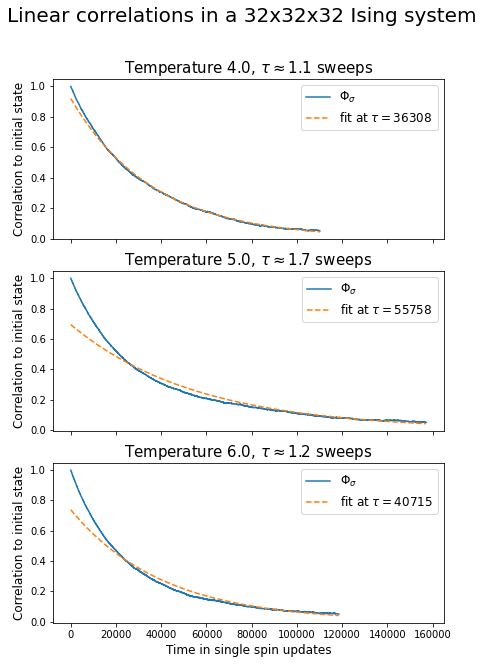

In [7]:
Perform_Linear_Correlation_Analysis(dataFrame_32, 32)

## 1.2 Nonlinear Tau Analysis
Next, we turn to equilibration. We perform the same analysis as above, but for $\Phi_\sigma^{nl}$.

Here we observe that the system typically equilibrates within a few sweeps. Note that again the automatic fits aren't perfect; e.g. for the 32x32x32 system we underestimate the relaxation time by a lot, some hand-tuning is required to improve the results. It looks like tau is about 5-10 sweeps, so we should discard the first ~30 sweeps to be on the safe side.

In [8]:
def Perform_Nonlinear_Correlation_Analysis(dataframe, linear_size):
    num_temps = int(dataframe.loc[:,"Number Of Temperatures"].values[0])
    fig,axs = plt.subplots(num_temps, sharex='all', figsize=(7,10))
    fig.suptitle(f"Nonlinear correlations in a {linear_size}x{linear_size}x{linear_size} Ising system", fontsize=20)
    for i in range(num_temps):
        name = f"Thermalization Magnetization {i}"
        temperature = dataframe.loc[:,f'Temperature {i}'].values[0]
        data = dataframe.loc[:,name].values
        sigma_infinity = data[-1]
        sigma_0 = data[0]
        phi_nl = (data - sigma_infinity) / (sigma_0 - sigma_infinity)
        upper_bound = 0
        while(phi_nl[upper_bound+1] > 0.1):
            upper_bound += 1
        if(upper_bound == 0):
            continue
        axs[i].plot(phi_nl[:upper_bound], label=r'$\Phi_\sigma^{nl}$')
        m,b = np.polyfit(np.arange(upper_bound),np.log(phi_nl[:upper_bound]),1)
        tau = -1./m
        axs[i].plot(np.exp(m*np.arange(upper_bound)+b), label=fr'fit at $\tau^{{nl}}={tau:.0f}$', ls='dashed')
        axs[i].set_title(fr"Temperature {temperature}, $\tau^{{nl}} \approx {tau/linear_size**3:.1f}$ sweeps", fontsize=15)
        axs[i].set_ylabel("Correlation to initial state", fontsize=12)
        axs[i].legend(prop={'size': 12})
    plt.xlabel('Time in single spin updates', fontsize=12)
    print(f"One sweep corresponds to {linear_size*linear_size*linear_size} updates")

One sweep corresponds to 512 updates


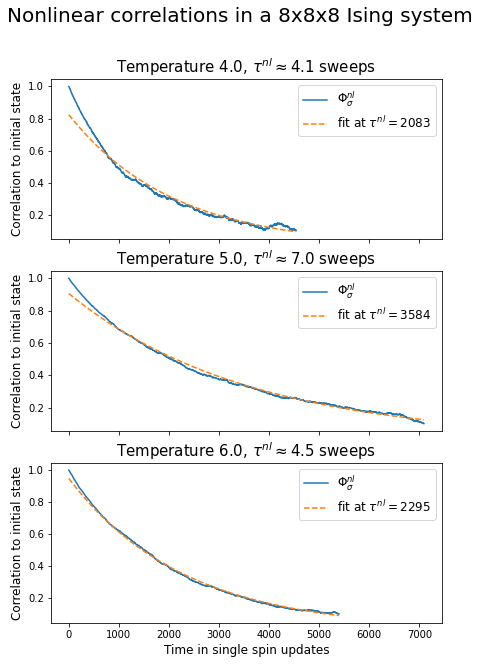

In [9]:
Perform_Nonlinear_Correlation_Analysis(dataFrame_8, 8)

One sweep corresponds to 4096 updates


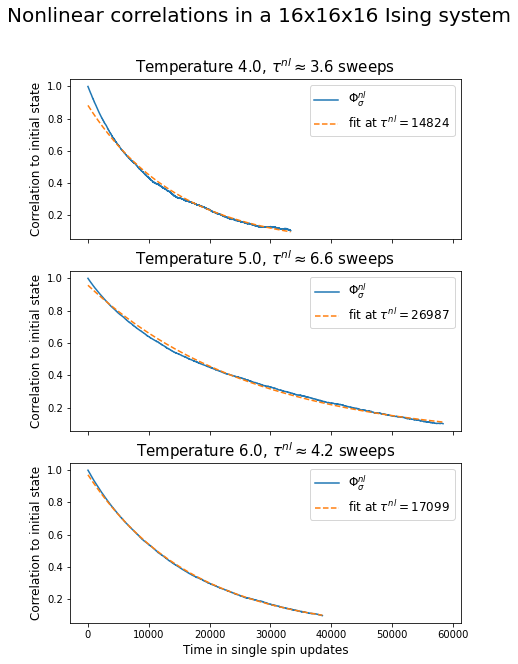

In [10]:
Perform_Nonlinear_Correlation_Analysis(dataFrame_16, 16)

One sweep corresponds to 32768 updates


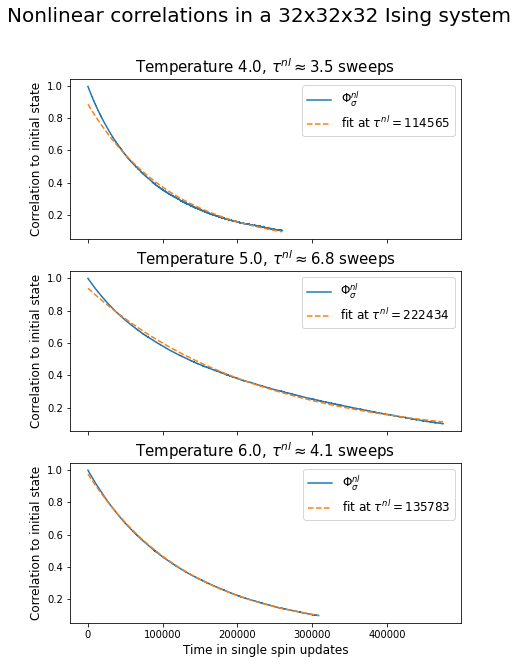

In [11]:
Perform_Nonlinear_Correlation_Analysis(dataFrame_32, 32)

## 1.3 Critical Region
Close to the critical region, the rules of the game change. Instead of the above, we should discard 
$\large c\cdot L^{z/\nu}$ samples. Here $z$ is the dynamical exponent depending on the update scheme, and $\nu$ is the correlation length critical exponent.

In [12]:
def critical_sample_stride(L):
    z = 2.09
    nu = 0.63
    return L**(z/nu)/L**3

In [13]:
print(f"L=8: Discard {3*np.ceil(critical_sample_stride(8)):.0f} sweeps.")
print(f"L=16: Discard {3*np.ceil(critical_sample_stride(16)):.0f} sweeps.")
print(f"L=32: Discard {3*np.ceil(critical_sample_stride(32)):.0f} sweeps.")

L=8: Discard 6 sweeps.
L=16: Discard 9 sweeps.
L=32: Discard 12 sweeps.


# 2. Observables and Critical Temperature
Now that we can sample decorrelated configurations, we want to see observables. The simulation details, mainly consisting of what was extracted above, can be found in `main.cpp` which is also used to generate the data. One important thing is that we cluster the target temperatures around the suspected critical point, because that's where everything happens: interesting things and problems.

Now we plot all of the observables data that we have. From the magnetic susceptibility, we also extract the critical temperature. That's an easy task, because we can just look at where the peak is. We find $T_c \approx 4.51$.

In [14]:
dataFrames = {}
system_sizes = [2, 4, 8, 16, 32]
for i in system_sizes:
    dataFrames[i] = pd.read_csv(f"data_3D_{i}.csv")

In [15]:
dataFrames[8]

,Temperature,Energy,Magnetization,Susceptibility,Capacity,Dimension,Length
0,2.61155,-2.853270,0.974106,0.026986,0.300451,3.0,8.0
1,2.96649,-2.721240,0.949028,0.052000,0.445211,NaN,NaN
2,3.27418,-2.556750,0.915440,0.092992,0.611413,NaN,NaN
3,3.53799,-2.372820,0.874496,0.157674,0.774014,NaN,NaN
4,3.76131,-2.172970,0.825223,0.270791,0.996808,NaN,NaN
5,3.94750,-1.968310,0.769148,0.417855,1.123450,NaN,NaN
6,4.09993,-1.786230,0.711659,0.667039,1.267550,NaN,NaN
7,4.22200,-1.592450,0.637108,1.398870,1.627990,NaN,NaN
8,4.31706,-1.434860,0.565818,2.332210,1.786640,NaN,NaN
9,4.38850,-1.317530,0.503853,2.893300,1.696850,NaN,NaN


In [16]:
alphas = {32: 1, 16: 0.7, 8: 0.5, 4: 0.4, 2: 0.3}

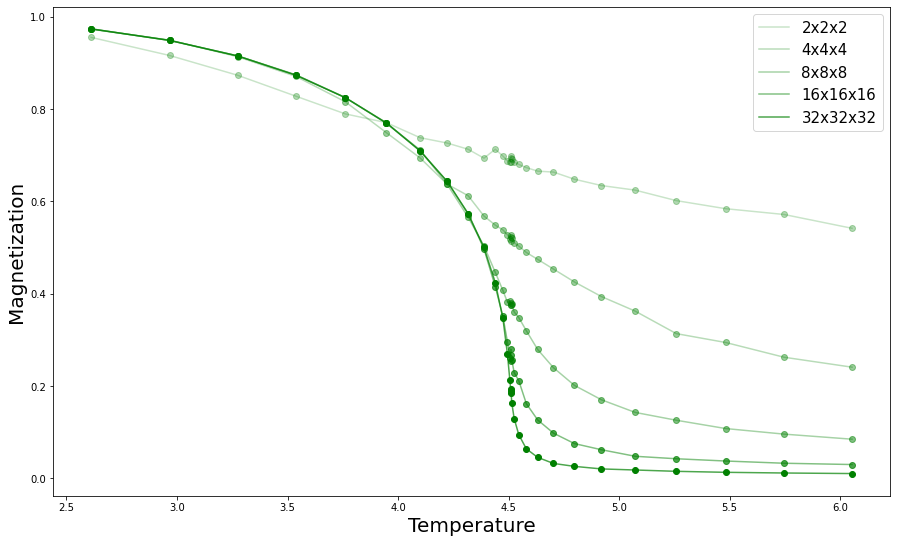

In [17]:
plt.figure(figsize=(15,9))
for i in system_sizes:
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Magnetization'].values), ls='-', alpha=alphas[i]*0.7, c='g', label=f"{i}x{i}x{i}")
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Magnetization'].values), 'o', alpha=alphas[i], c='g')
plt.legend(prop={'size': 15})
plt.xlabel("Temperature", size=20)
plt.ylabel("Magnetization", size=20)
plt.show()

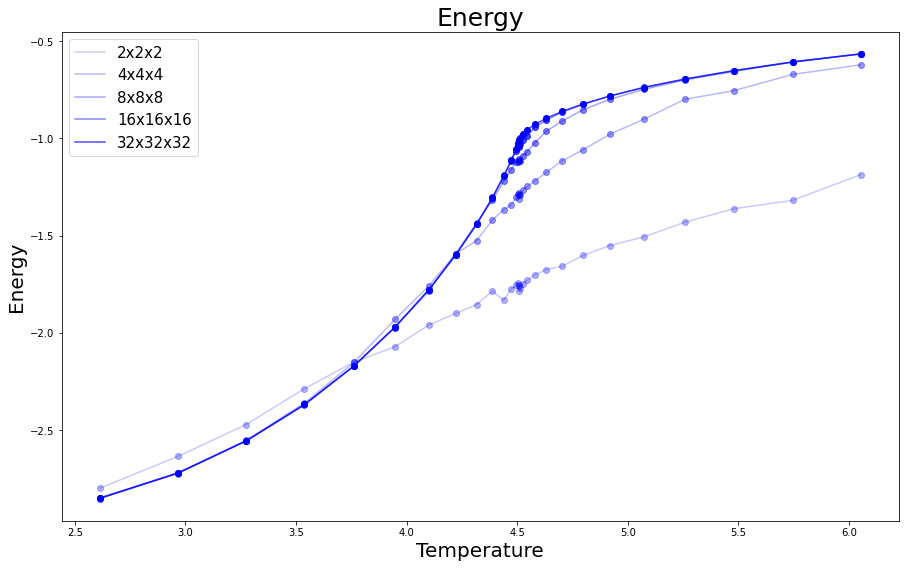

In [18]:
plt.figure(figsize=(15,9))
for i in system_sizes:
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, dataFrames[i].loc[:,'Energy'].values, ls='-', alpha=alphas[i]*0.7, c='b', label=f"{i}x{i}x{i}")
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, dataFrames[i].loc[:,'Energy'].values, 'o', alpha=alphas[i], c='b')
plt.legend(prop={'size': 15})
plt.title("Energy", size=25)
plt.xlabel("Temperature", size=20)
plt.ylabel("Energy", size=20)
plt.show()

Tc ~ 4.51


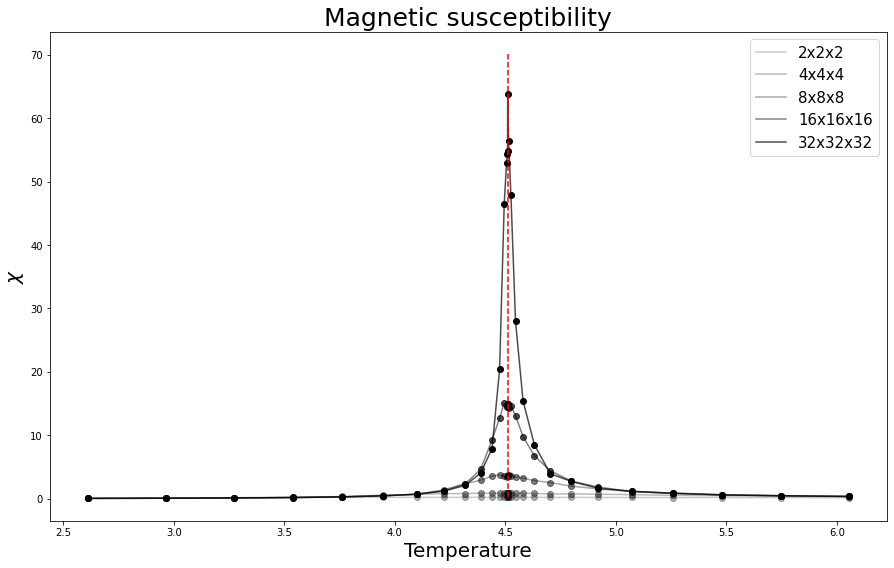

In [19]:
plt.figure(figsize=(15,9))
for i in system_sizes:
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Susceptibility'].values), ls='-', alpha=alphas[i]*0.7, c='k', label=f"{i}x{i}x{i}")
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Susceptibility'].values), 'o', alpha=alphas[i], c='k')
#identify critical temperature as peak of the 32x32x32 susceptibility
max_index = np.argmax(dataFrames[32].loc[:,'Susceptibility'].values)
chim = dataFrames[32].loc[:,'Susceptibility'].values[max_index]
Tc = dataFrames[32].loc[:,'Temperature'].values[max_index]
print(f"Tc ~ {Tc:.2f}")
plt.plot([Tc,Tc],[1.1*chim,0.],c='red', ls='dashed')
plt.legend(prop={'size': 15})
plt.title("Magnetic susceptibility", size=25)
plt.xlabel("Temperature", size=20)
plt.ylabel(r"$\chi$", size=20)
plt.show()

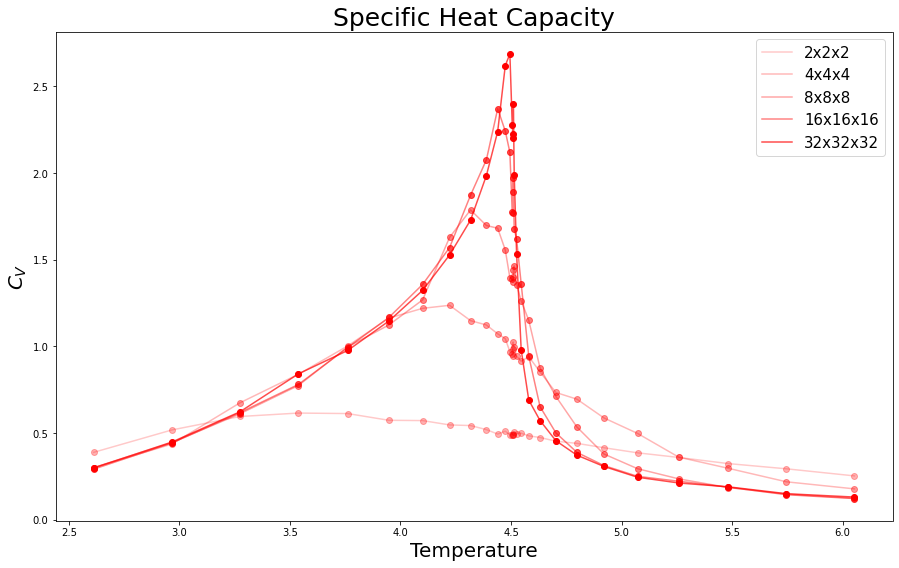

In [20]:
plt.figure(figsize=(15,9))
for i in system_sizes:
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Capacity'].values), ls='-', alpha=alphas[i]*0.7, c='r', label=f"{i}x{i}x{i}")
    plt.plot(dataFrames[i].loc[:,'Temperature'].values, np.abs(dataFrames[i].loc[:,'Capacity'].values), 'o', alpha=alphas[i], c='r')
plt.legend(prop={'size': 15})
plt.title("Specific Heat Capacity", size=25)
plt.ylabel(r"$C_V$", size=20)
plt.xlabel(r"Temperature", size=20)
plt.show()

# 3. Extracting Critical Exponents
We want to extract the critical exponents $\nu,\;\gamma$. Thus we should have a look at the behaviour of the susceptibility $\chi$. In the end, we want to achieve data collapse, as described in the exercise class. To get there, we first need a good estimate for the critical exponents.

The crucial observation to achieve this is the finite size scaling of the susceptibility peak height,

\begin{equation}
\large
\chi_\max(L) \sim L^{\gamma/\nu} \quad\Longrightarrow \quad \log\chi_\max(L) \sim \frac{\gamma}{\nu}\log L.
\end{equation}

The susceptibility maxima plotted logarithmically as a function of system size should yield points on a straight line, with inclination $\large\gamma/\nu$. This is how we find one of the exponents.

gamma/nu: 2.08
Literature value of gamma/nu: 1.97


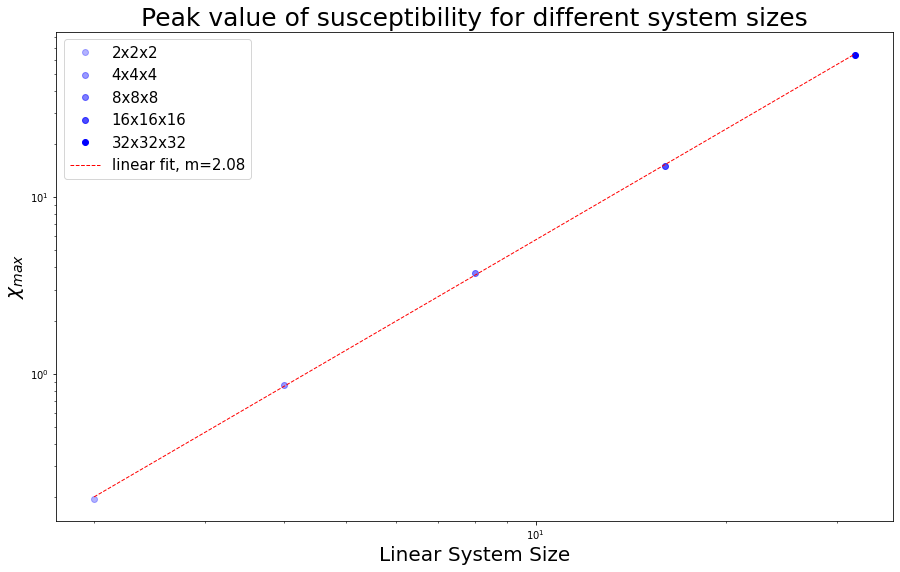

In [21]:
chi_max = {}
indices = {}
chimaxs = []
for s in system_sizes:
    chi_max[s] = np.max(dataFrames[s].loc[:,'Susceptibility'].values)
    indices[s] = np.argmax(dataFrames[s].loc[:,'Susceptibility'].values)
    chimaxs.append(chi_max[s])
m,b = np.polyfit(np.log(system_sizes),np.log(chimaxs),1)

plt.figure(figsize=(15,9))
for s in system_sizes:
    plt.loglog([s],[chi_max[s]],'o', c='b', alpha=alphas[s], label=f'{s}x{s}x{s}')
plt.loglog(np.exp(np.log(system_sizes)), np.exp(m*np.log(system_sizes) + b), ls='--', lw=1, c='r', label=f"linear fit, m={m:.2f}")
plt.legend(prop={'size': 15})
plt.title("Peak value of susceptibility for different system sizes", size=25)
plt.ylabel(r"$\chi_{max}$", size=20)
plt.xlabel(r"Linear System Size", size=20)
print(f"gamma/nu: {m:.2f}")
lit_gamma = 1.24
lit_nu = 0.63
print(f"Literature value of gamma/nu: {lit_gamma/lit_nu:.2f}")

Next, we can plot our data collapse and only vary the other exponent, until it all collapses as well as possible. One could take this further and keep iterating until the best collapse is achieved.

nu: 0.64
gamma: 1.34


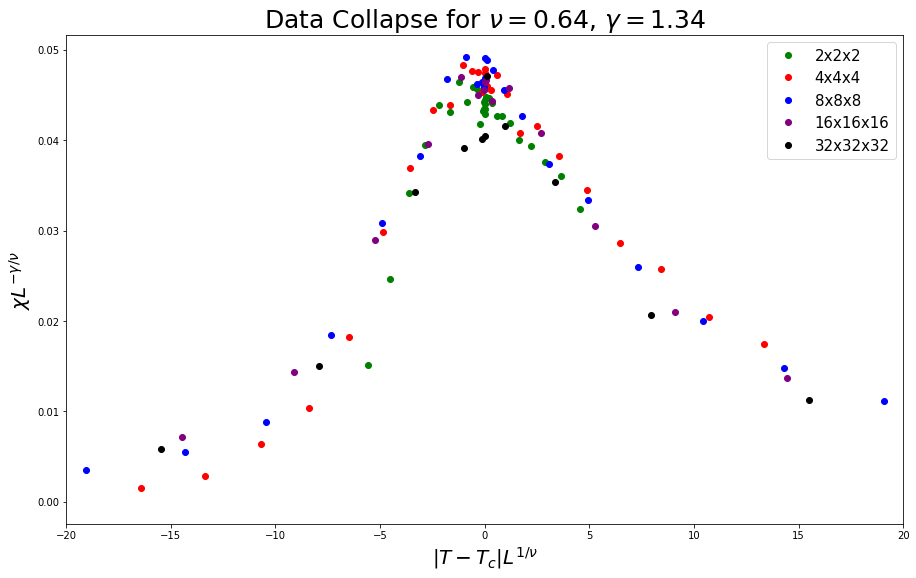

In [32]:
nu = 1.15*0.558575
gamma = m * nu
print(f"nu: {nu:.2f}")
print(f"gamma: {gamma:.2f}")

colors = {32: "black", 16: "purple", 8: "blue", 4: "red", 2: "green"}
plt.figure(figsize=(15,9))
for s in system_sizes:
    plt.plot((dataFrames[s].loc[:,'Temperature'].values-4.51)*s**(1./nu),s**(-m)*dataFrames[s].loc[:,'Susceptibility'].values, 'o', c=colors[s], alpha=1, label=f'{s}x{s}x{s}')
    #plt.loglog(np.abs(dataFrames[s].loc[:,'Temperature'].values-dataFrames[s].loc[:,'Temperature'].values[indices[s]])*s,s**(-m)*dataFrames[s].loc[:,'Susceptibility'].values, 'o', c='purple', alpha=alphas[s])
plt.title(fr"Data Collapse for $\nu = ${nu:.2f}, $\gamma = ${gamma:.2f}", fontsize=25)
plt.ylabel(r'$\chi L^{-\gamma/\nu}$', size=20)
plt.xlabel(r'$\|T-T_c|L^{1/\nu}$', size=20)
plt.legend(prop={'size': 15})
plt.xlim([-20,20])
plt.show()